In [1]:
import sys
sys.path.append("../src/")
from ECALDataAnalyzer import ECALDataAnalyzer
#from plot_tools_ecal import plot_ecal_peaks, plot_ecal_peaks_with_intersections
from TrainData import TrainData
import pandas as pd
import pandas as pd
import numpy as np
from itertools import combinations
from ECALDataReader import ECALDataReader
from ECALDataProcessor import ECALDataProcessor
import csv
from tqdm import tqdm

In [2]:
    
def closest_point_between_lines(a1, b1, a2, b2):
    """
    Calculate the closest point between two lines in 2D space.
    
    Parameters:
    -----------
    a1, b1 : numpy.ndarray
        The starting point and direction vector for the first line.
    a2, b2 : numpy.ndarray
        The starting point and direction vector for the second line.
        
    Returns:
    --------
    numpy.ndarray
        The closest point between the two lines.
    """
    b1 = b1 / np.linalg.norm(b1)
    b2 = b2 / np.linalg.norm(b2)
    a_diff = a2 - a1
    det = b1[0] * b2[1] - b1[1] * b2[0]
    
    if np.isclose(det, 0):
        lambda_1 = np.dot(a_diff, b1)
        closest_point_1 = a1 + lambda_1 * b1
        return closest_point_1
    else:
        lambda_ = (a_diff[0] * b2[1] - a_diff[1] * b2[0]) / det
        closest_point = a1 + lambda_ * b1
        return closest_point

def calculate_centroid_and_intersection(df, n_values, R=0.5):
    """
    Calculate the centroid of closest points between lines in different layers
    and determine if they form valid intersections.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing line data with columns ['xo', 'yo', 'xe', 'ye', 'layer', etc.].
    n_values : list of int
        List of layer indices to consider for intersections.
    R : float
        Radius within which the centroid must lie for the intersection to be valid.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing valid intersections with centroid positions and associated data.
    """
    results = []

    grouped = df.groupby('event_number')

    for event, group in grouped:
        for n in n_values:
            layer_n = group[group['layer'] == n]
            layer_n1 = group[group['layer'] == n+1]
            layer_n2 = group[group['layer'] == n+2]

            for _, lineA in layer_n.iterrows():
                for _, lineB in layer_n1.iterrows():
                    for _, lineC in layer_n2.iterrows():
                        # Calculate the closest points
                        aA, bA = np.array([lineA['xo'], lineA['yo']]), np.array([lineA['xe'], lineA['ye']]) - np.array([lineA['xo'], lineA['yo']])
                        aB, bB = np.array([lineB['xo'], lineB['yo']]), np.array([lineB['xe'], lineB['ye']]) - np.array([lineB['xo'], lineB['yo']])
                        aC, bC = np.array([lineC['xo'], lineC['yo']]), np.array([lineC['xe'], lineC['ye']]) - np.array([lineC['xo'], lineC['yo']])
                        
                        closest_AB = closest_point_between_lines(aA, bA, aB, bB)
                        closest_AC = closest_point_between_lines(aA, bA, aC, bC)
                        closest_BC = closest_point_between_lines(aB, bB, aC, bC)
                        
                        centroid = (closest_AB + closest_AC + closest_BC) / 3
                        
                        distances = [
                            np.linalg.norm(closest_AB - centroid),
                            np.linalg.norm(closest_AC - centroid),
                            np.linalg.norm(closest_BC - centroid)
                        ]
                        
                        if all(distance <= R for distance in distances):
                            mc_pid = lineA['mc_pid'] if lineA['mc_pid'] == lineB['mc_pid'] == lineC['mc_pid'] else -1
                            otid = lineA['otid'] if lineA['otid'] == lineB['otid'] == lineC['otid'] else -1
                            sector = lineA['sector'] if lineA['sector'] == lineB['sector'] == lineC['sector'] else -1
                            rec_pid = lineA['rec_pid'] if lineA['rec_pid'] == lineB['rec_pid'] == lineC['rec_pid'] else -1
                            pindex = lineA['pindex'] if lineA['pindex'] == lineB['pindex'] == lineC['pindex'] else -1
                            if sector == -1:  # The cluster must come from intersecting strips in the same sector
                                continue
                            results.append({
                                'event_number': event,
                                'centroid_x': centroid[0],
                                'centroid_y': centroid[1],
                                'time_A'  : lineA['time'],
                                'time_B'  : lineB['time'],
                                'time_C'  : lineC['time'],
                                'energy_A'  : lineA['energy'],
                                'energy_B'  : lineB['energy'],
                                'energy_C'  : lineC['energy'],
                                'layer': 1+(n-1)/3,
                                'sector': sector,
                                'mc_pid': mc_pid,
                                'otid': otid,
                                'rec_pid': rec_pid,
                                'pindex': pindex,
                                'xo_A': lineA['xo'], 'yo_A': lineA['yo'], 'xe_A': lineA['xe'], 'ye_A': lineA['ye'],
                                'xo_B': lineB['xo'], 'yo_B': lineB['yo'], 'xe_B': lineB['xe'], 'ye_B': lineB['ye'],
                                'xo_C': lineC['xo'], 'yo_C': lineC['yo'], 'xe_C': lineC['xe'], 'ye_C': lineC['ye'],
                            })
    return pd.DataFrame(results)

def line_intersection(a1, b1, a2, b2):
    """
    Calculate the intersection point of two line segments in 2D space.
    
    Parameters:
    -----------
    a1, b1 : numpy.ndarray
        The starting point and direction vector for the first line.
    a2, b2 : numpy.ndarray
        The starting point and direction vector for the second line.
        
    Returns:
    --------
    numpy.ndarray or None
        The intersection point of the two line segments if they intersect, otherwise None.
    """
    b1 = b1 / np.linalg.norm(b1)
    b2 = b2 / np.linalg.norm(b2)
    a_diff = a2 - a1
    det = b1[0] * b2[1] - b1[1] * b2[0]
    
    if np.isclose(det, 0):  # Lines are parallel or coincident
        return None
    else:
        lambda_ = (a_diff[0] * b2[1] - a_diff[1] * b2[0]) / det
        intersection = a1 + lambda_ * b1
        
        # Check if the intersection point lies within the bounding box of both segments
        if (
            np.amin([a1[0], a1[0] + b1[0], a2[0], a2[0] + b2[0]]) <= intersection[0] <= np.amax([a1[0], a1[0] + b1[0], a2[0], a2[0] + b2[0]]) and
            np.amin([a1[1], a1[1] + b1[1], a2[1], a2[1] + b2[1]]) <= intersection[1] <= np.amax([a1[1], a1[1] + b1[1], a2[1], a2[1] + b2[1]])
        ):
            return intersection
        else:
            return None

In [34]:
class ECALDataAnalyzer:
    """
    Class to analyze ECAL data and write the results to a CSV file.
    """

    def __init__(self, input_filename, output_filename="output.csv"):
        """
        Initialize the analyzer with input and output file names.
        
        Parameters:
        -----------
        input_filename : str
            Path to the input hipo file.
        output_filename : str
            Path to the initial output CSV file for hits (default is "output.csv").
        """
        self.input_filename = input_filename
        self.output_filename = output_filename

    def read_ecal_data_from_event(self):
        """
        Read and process ECAL data from an event file and write results to a CSV.
        """
        reader = ECALDataReader(self.input_filename)
        
        # Open the CSV file for writing
        with open(self.output_filename, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # Write the header row
            header = [
                "event_number", "id", "mc_pid", "otid", "sector", "layer", "energy", "time", 
                "xo", "yo", "zo", "xe", "ye", "ze", "rec_pid", "pindex"
            ]
            csv_writer.writerow(header)

            # Loop over the events and process the data
            for event_number, event in tqdm(enumerate(reader.file)):
                ECAL_hits = reader.get_dict("ECAL::hits+")
                if(len(ECAL_hits)==0): # Skip events without ECAL hits
                    continue
                REC_cal = reader.get_dict("REC::Calorimeter")
                REC_parts = reader.get_dict("REC::Particle")

                # Apply the rec_pid and pindex determination
                def get_rec_pid_and_pindex(row):
                    if row['clusterId'] == -1:
                        return pd.Series({'rec_pid': -1, 'pindex': -1})
                    else:
                        pindex = REC_cal[REC_cal["index"] == row['clusterId'] - 1]["pindex"].values[0]
                        rec_pid = REC_parts["pid"].values[pindex]
                        return pd.Series({'rec_pid': rec_pid, 'pindex': pindex})

                # Add rec_pid and pindex columns to ECAL_hits DataFrame
                ECAL_hits[['rec_pid', 'pindex']] = ECAL_hits.apply(get_rec_pid_and_pindex, axis=1)

                # Write the data for each hit to the CSV file
                for _, hit in ECAL_hits.iterrows():
                    row = [
                        event_number, hit['id'], hit['pid'], hit['otid'], hit['sector'], hit['layer'], hit['energy'], hit['time'],
                        hit['xo'], hit['yo'], hit['zo'], hit['xe'], hit['ye'], hit['ze'], hit['rec_pid'], hit['pindex']
                    ]
                    csv_writer.writerow(row)

    def process_hipo(self):
        """
        Process the hipo file to generate a CSV with hits data.
        """
        # Generate the initial hits CSV
        self.read_ecal_data_from_event()
        
        # Add the centroid column
        self.add_centroid_columns(R=6)
        print(f"Processing complete.")

    
    def add_centroid_columns(self, R=6):
        # Load the hits data from the previously generated CSV
        df = pd.read_csv(self.output_filename)

        # Initialize centroid columns with default values
        df['centroid_x'] = 0.0
        df['centroid_y'] = 0.0

        # Initialize one-hot encoded columns for intersection types
        df['is_3way_same_group'] = 0
        df['is_2way_same_group'] = 0
        df['is_3way_cross_group'] = 0
        df['is_2way_cross_group'] = 0

        # Process each event_number and sector group
        df = self.process_groups(df, R)

        # Process cross-layer group intersections for remaining strips
        df = self.process_cross_groups(df, R)

        # Save the updated DataFrame back to the original CSV file
        df.to_csv(self.output_filename, index=False)
        print(f"Centroid columns and intersection types added, CSV saved: {self.output_filename}")

        
    def process_groups(self, df, R):
        """
        Process each group of event_number and sector in the DataFrame.

        Parameters:
        -----------
        df : pd.DataFrame
            The DataFrame to process.
        R : float
            The maximum allowed distance for considering a 3-way intersection as valid.

        Returns:
        --------
        pd.DataFrame
            The updated DataFrame with centroids and intersection flags set.
        """
        # Group the data by event number and sector
        grouped = df.groupby(['event_number', 'sector'])

        # Iterate through each event and sector group
        for (event_number, sector), group in tqdm(grouped):
            for n_start in [1, 4, 7]:
                layer_group = group[group['layer'].isin([n_start, n_start + 1, n_start + 2])]
                df = self.process_layer_group(df, layer_group, event_number, sector, R)

        return df

    def process_layer_group(self, df, layer_group, event_number, sector, R):
        """
        Process each strip within a layer group, searching for 3-way and 2-way intersections.

        Parameters:
        -----------
        df : pd.DataFrame
            The DataFrame being updated.
        layer_group : pd.DataFrame
            The subset of data for a specific event_number, sector, and layer group.
        event_number : int
            The event number for the group being processed.
        sector : int
            The sector number for the group being processed.
        R : float
            The maximum allowed distance for considering a 3-way intersection as valid.

        Returns:
        --------
        pd.DataFrame
            The updated DataFrame.
        """
        for _, strip_x in layer_group.iterrows():
            if strip_x['centroid_x'] == 0 and strip_x['centroid_y'] == 0:
                # Search for the most energetic 3-way intersection
                max_energy, best_centroid, matched_strips = self.find_best_3way_intersection(strip_x, layer_group, R)
                if max_energy > 0:
                    df = self.update_centroid(df, event_number, matched_strips, best_centroid, 'is_3way_same_group')
                    continue

                # If no 3-way found, search for the most energetic 2-way intersection within the same layer group
                max_energy, best_centroid, matched_strips = self.find_best_2way_intersection(strip_x, layer_group)
                if max_energy > 0:
                    df = self.update_centroid(df, event_number, matched_strips, best_centroid, 'is_2way_same_group')

        return df

    def process_cross_groups(self, df, R):
        """
        Process strips that haven't found a centroid within their layer group, searching across groups.

        Parameters:
        -----------
        df : pd.DataFrame
            The DataFrame being updated.
        R : float
            The maximum allowed distance for considering a 3-way intersection as valid.

        Returns:
        --------
        pd.DataFrame
            The updated DataFrame.
        """
        # Group the data by event number and sector
        grouped = df.groupby(['event_number', 'sector'])

        # Iterate through each event and sector group
        for (event_number, sector), group in tqdm(grouped):
            # Separate the layer groups within the current event and sector
            layer_groups = {n_start: group[group['layer'].isin([n_start, n_start + 1, n_start + 2])]
                            for n_start in [1, 4, 7]}

            for n_start, layer_group in layer_groups.items():
                for _, strip_x in layer_group.iterrows():
                    if strip_x['centroid_x'] == 0 and strip_x['centroid_y'] == 0:
                        # Search for 3-way intersections across non-matching layer groups
                        max_energy, best_centroid, matched_strips = self.find_best_3way_intersection(strip_x, group, R, cross_group=True)
                        if max_energy > 0:
                            df = self.update_centroid(df, strip_x['event_number'], matched_strips, best_centroid, 'is_3way_cross_group')
                            continue

                        # If no 3-way found, search for 2-way intersections across all layer groups
                        max_energy, best_centroid, matched_strips = self.find_best_2way_intersection(strip_x, group, cross_group=True)
                        if max_energy > 0:
                            df = self.update_centroid(df, strip_x['event_number'], matched_strips, best_centroid, 'is_2way_cross_group')

        return df
    

    def find_best_3way_intersection(self, strip_x, layer_group, R, cross_group=False):
        """
        Find the most energetic 3-way intersection for a given strip.

        Parameters:
        -----------
        strip_x : pd.Series
            The strip being processed.
        layer_group : pd.DataFrame
            The subset of data within the layer group or cross groups.
        R : float
            The maximum allowed distance for considering a 3-way intersection as valid.
        cross_group : bool
            If True, search across all layers, not just within the layer group.

        Returns:
        --------
        tuple : (max_energy, best_centroid, matched_strips)
            max_energy : float
                The energy of the best 3-way intersection found.
            best_centroid : np.array
                The centroid coordinates of the best intersection.
            matched_strips : list
                The IDs of strips involved in the best intersection.
        """
        max_energy = 0
        best_centroid = np.array([0.0, 0.0])
        matched_strips = []

        for _, strip_n1 in layer_group.iterrows():
            for _, strip_n2 in layer_group.iterrows():
                if strip_n1['id'] == strip_n2['id'] or strip_x['id'] == strip_n1['id'] or strip_x['id'] == strip_n2['id']:
                    continue

                # Calculate closest points between lines
                closest_n_n1 = closest_point_between_lines(
                    np.array([strip_x['xo'], strip_x['yo']]),
                    np.array([strip_x['xe'], strip_x['ye']]) - np.array([strip_x['xo'], strip_x['yo']]),
                    np.array([strip_n1['xo'], strip_n1['yo']]),
                    np.array([strip_n1['xe'], strip_n1['ye']]) - np.array([strip_n1['xo'], strip_n1['yo']])
                )
                closest_n_n2 = closest_point_between_lines(
                    np.array([strip_x['xo'], strip_x['yo']]),
                    np.array([strip_x['xe'], strip_x['ye']]) - np.array([strip_x['xo'], strip_x['yo']]),
                    np.array([strip_n2['xo'], strip_n2['yo']]),
                    np.array([strip_n2['xe'], strip_n2['ye']]) - np.array([strip_n2['xo'], strip_n2['yo']])
                )
                closest_n1_n2 = closest_point_between_lines(
                    np.array([strip_n1['xo'], strip_n1['yo']]),
                    np.array([strip_n1['xe'], strip_n1['ye']]) - np.array([strip_n1['xo'], strip_n1['yo']]),
                    np.array([strip_n2['xo'], strip_n2['yo']]),
                    np.array([strip_n2['xe'], strip_n2['ye']]) - np.array([strip_n2['xo'], strip_n2['yo']])
                )

                centroid = (closest_n_n1 + closest_n_n2 + closest_n1_n2) / 3
                distances = [
                    np.linalg.norm(closest_n_n1 - centroid),
                    np.linalg.norm(closest_n_n2 - centroid),
                    np.linalg.norm(closest_n1_n2 - centroid)
                ]

                if all(distance <= R for distance in distances):
                    total_energy = strip_x['energy'] + strip_n1['energy'] + strip_n2['energy']
                    if total_energy > max_energy:
                        max_energy = total_energy
                        best_centroid = centroid
                        matched_strips = [strip_x['id']]

        return max_energy, best_centroid, matched_strips

    def find_best_2way_intersection(self, strip_x, layer_group, cross_group=False):
        """
        Find the most energetic 2-way intersection for a given strip.

        Parameters:
        -----------
        strip_x : pd.Series
            The strip being processed.
        layer_group : pd.DataFrame
            The subset of data within the layer group or cross groups.
        cross_group : bool
            If True, search across all layers, not just within the layer group.

        Returns:
        --------
        tuple : (max_energy, best_centroid, matched_strips)
            max_energy : float
                The energy of the best 2-way intersection found.
            best_centroid : np.array
                The centroid coordinates of the best intersection.
            matched_strips : list
                The IDs of strips involved in the best intersection.
        """
        max_energy = 0
        best_centroid = np.array([0.0, 0.0])
        matched_strips = []

        for _, strip_n1 in layer_group.iterrows():
            if strip_x['id'] == strip_n1['id']:
                continue

            # Calculate 2-way intersection
            intersection = line_intersection(
                np.array([strip_x['xo'], strip_x['yo']]),
                np.array([strip_x['xe'], strip_x['ye']]) - np.array([strip_x['xo'], strip_x['yo']]),
                np.array([strip_n1['xo'], strip_n1['yo']]),
                np.array([strip_n1['xe'], strip_n1['ye']]) - np.array([strip_n1['xo'], strip_n1['yo']])
            )

            if intersection is not None:
                total_energy = strip_x['energy'] + strip_n1['energy']
                if total_energy > max_energy:
                    max_energy = total_energy
                    best_centroid = intersection
                    matched_strips = [strip_x['id']]

        return max_energy, best_centroid, matched_strips

    def update_centroid(self, df, event_number, matched_strips, centroid, intersection_type):
        """
        Update the centroid columns and one-hot encoded intersection flags in the DataFrame.

        Parameters:
        -----------
        df : pd.DataFrame
            The DataFrame being updated.
        event_number : int
            The event number of the strips being updated.
        matched_strips : list
            The IDs of the strips involved in the intersection.
        centroid : np.array
            The centroid coordinates to set.
        intersection_type : str
            The type of intersection (one of 'is_3way_same_group', 'is_2way_same_group', 'is_3way_cross_group', 'is_2way_cross_group').

        Returns:
        --------
        pd.DataFrame
            The updated DataFrame.
        """
        for strip_id in matched_strips:
            idx = df[(df['event_number'] == event_number) & (df['id'] == strip_id)].index
            df.loc[idx, 'centroid_x'] = centroid[0]
            df.loc[idx, 'centroid_y'] = centroid[1]
            df.loc[idx, intersection_type] = 1

        return df


In [35]:

    
#     def add_centroid_columns(self, R=6):
#         """
#         Add centroid_x and centroid_y columns to the original CSV file based on the intersection 
#         of strips across layers within the specified layer groups. Additionally, add one-hot encoded
#         columns to indicate the type of intersection (3-way, 2-way within the same layer group, 
#         or 2-way across any layer group).
#         """
#         # Load the hits data from the previously generated CSV
#         df = pd.read_csv(self.output_filename)

#         # Initialize centroid columns with default values
#         df['centroid_x'] = 0.0
#         df['centroid_y'] = 0.0

#         # Initialize one-hot encoded columns for intersection types
#         df['is_3way_intersection'] = 0
#         df['is_2way_same_group'] = 0
#         df['is_2way_any_group'] = 0

#         # Group the data by event number and sector
#         grouped = df.groupby(['event_number', 'sector'])

#         # Iterate through each event and sector group
#         for (event_number, sector), group in grouped:
#             for n_start in [1, 4, 7]:
#                 # Select the relevant layers
#                 layer_n = group[group['layer'] == n_start]
#                 layer_n1 = group[group['layer'] == n_start + 1]
#                 layer_n2 = group[group['layer'] == n_start + 2]

#                 for _, strip_n in layer_n.iterrows():
#                     max_energy = 0
#                     best_centroid = np.array([0.0, 0.0])
#                     matched_strips = []
#                     intersection_type = None

#                     # Try to find 3-way intersections first
#                     for _, strip_n1 in layer_n1.iterrows():
#                         for _, strip_n2 in layer_n2.iterrows():
#                             closest_n_n1 = closest_point_between_lines(
#                                 np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n['xe'], strip_n['ye']]) - np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n1['xo'], strip_n1['yo']]),
#                                 np.array([strip_n1['xe'], strip_n1['ye']]) - np.array([strip_n1['xo'], strip_n1['yo']])
#                             )
#                             closest_n_n2 = closest_point_between_lines(
#                                 np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n['xe'], strip_n['ye']]) - np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n2['xo'], strip_n2['yo']]),
#                                 np.array([strip_n2['xe'], strip_n2['ye']]) - np.array([strip_n2['xo'], strip_n2['yo']])
#                             )
#                             closest_n1_n2 = closest_point_between_lines(
#                                 np.array([strip_n1['xo'], strip_n1['yo']]),
#                                 np.array([strip_n1['xe'], strip_n1['ye']]) - np.array([strip_n1['xo'], strip_n1['yo']]),
#                                 np.array([strip_n2['xo'], strip_n2['yo']]),
#                                 np.array([strip_n2['xe'], strip_n2['ye']]) - np.array([strip_n2['xo'], strip_n2['yo']])
#                             )

#                             centroid = (closest_n_n1 + closest_n_n2 + closest_n1_n2) / 3
#                             distances = [
#                                 np.linalg.norm(closest_n_n1 - centroid),
#                                 np.linalg.norm(closest_n_n2 - centroid),
#                                 np.linalg.norm(closest_n1_n2 - centroid)
#                             ]

#                             if all(distance <= R for distance in distances):
#                                 total_energy = strip_n['energy'] + strip_n1['energy'] + strip_n2['energy']
#                                 if total_energy > max_energy:
#                                     max_energy = total_energy
#                                     best_centroid = centroid
#                                     matched_strips = [strip_n['id'], strip_n1['id'], strip_n2['id']]
#                                     intersection_type = '3way'

#                     # If no valid 3-way intersection found, try to find 2-way intersections within the same layer group
#                     if max_energy == 0:
#                         for _, strip_n1 in layer_n1.iterrows():
#                             intersection = line_intersection(
#                                 np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n['xe'], strip_n['ye']]) - np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n1['xo'], strip_n1['yo']]),
#                                 np.array([strip_n1['xe'], strip_n1['ye']]) - np.array([strip_n1['xo'], strip_n1['yo']])
#                             )
#                             if intersection is not None:
#                                 total_energy = strip_n['energy'] + strip_n1['energy']
#                                 if total_energy > max_energy:
#                                     max_energy = total_energy
#                                     best_centroid = intersection
#                                     matched_strips = [strip_n['id'], strip_n1['id']]
#                                     intersection_type = '2way_same'

#                         for _, strip_n2 in layer_n2.iterrows():
#                             intersection = line_intersection(
#                                 np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n['xe'], strip_n['ye']]) - np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n2['xo'], strip_n2['yo']]),
#                                 np.array([strip_n2['xe'], strip_n2['ye']]) - np.array([strip_n2['xo'], strip_n2['yo']])
#                             )
#                             if intersection is not None:
#                                 total_energy = strip_n['energy'] + strip_n2['energy']
#                                 if total_energy > max_energy:
#                                     max_energy = total_energy
#                                     best_centroid = intersection
#                                     matched_strips = [strip_n['id'], strip_n2['id']]
#                                     intersection_type = '2way_same'

#                     # If still no valid intersection found, try 2-way intersections across all layers in the sector
#                     if max_energy == 0:
#                         for _, other_strip in group.iterrows():
#                             if other_strip['id'] == strip_n['id']:
#                                 continue
#                             intersection = line_intersection(
#                                 np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([strip_n['xe'], strip_n['ye']]) - np.array([strip_n['xo'], strip_n['yo']]),
#                                 np.array([other_strip['xo'], other_strip['yo']]),
#                                 np.array([other_strip['xe'], other_strip['ye']]) - np.array([other_strip['xo'], other_strip['yo']])
#                             )
#                             if intersection is not None:
#                                 total_energy = strip_n['energy'] + other_strip['energy']
#                                 if total_energy > max_energy:
#                                     max_energy = total_energy
#                                     best_centroid = intersection
#                                     matched_strips = [strip_n['id'], other_strip['id']]
#                                     intersection_type = '2way_any'

#                     # Update the centroid columns and intersection type for all matched strips in the DataFrame
#                     for strip_id in matched_strips:
#                         idx = df[(df['event_number'] == event_number) & (df['id'] == strip_id)].index
#                         df.loc[idx, 'centroid_x'] = best_centroid[0]
#                         df.loc[idx, 'centroid_y'] = best_centroid[1]

#                         # Set the appropriate one-hot encoded column
#                         if intersection_type == '3way':
#                             df.loc[idx, 'is_3way_intersection'] = 1
#                         elif intersection_type == '2way_same':
#                             df.loc[idx, 'is_2way_same_group'] = 1
#                         elif intersection_type == '2way_any':
#                             df.loc[idx, 'is_2way_any_group'] = 1

#         # Save the updated DataFrame back to the original CSV file
#         df.to_csv(self.output_filename, index=False)
#         print(f"Centroid columns and intersection types added, CSV saved: {self.output_filename}")
    

In [36]:
ana = ECALDataAnalyzer(input_filename = '/w/hallb-scshelf2102/clas12/users/gmat/clas12/coatjava_dev/coatjava/playground/output/08_20_2024_0002/cooked.hipo',
                       output_filename = 'output.csv')
ana.process_hipo()

101it [00:04, 22.60it/s]
100%|████████████████████████████████████████| 380/380 [00:49<00:00,  7.71it/s]

Centroid columns and intersection types added, CSV saved: output.csv
Processing complete.


In [19]:
df = pd.read_csv("output.csv")

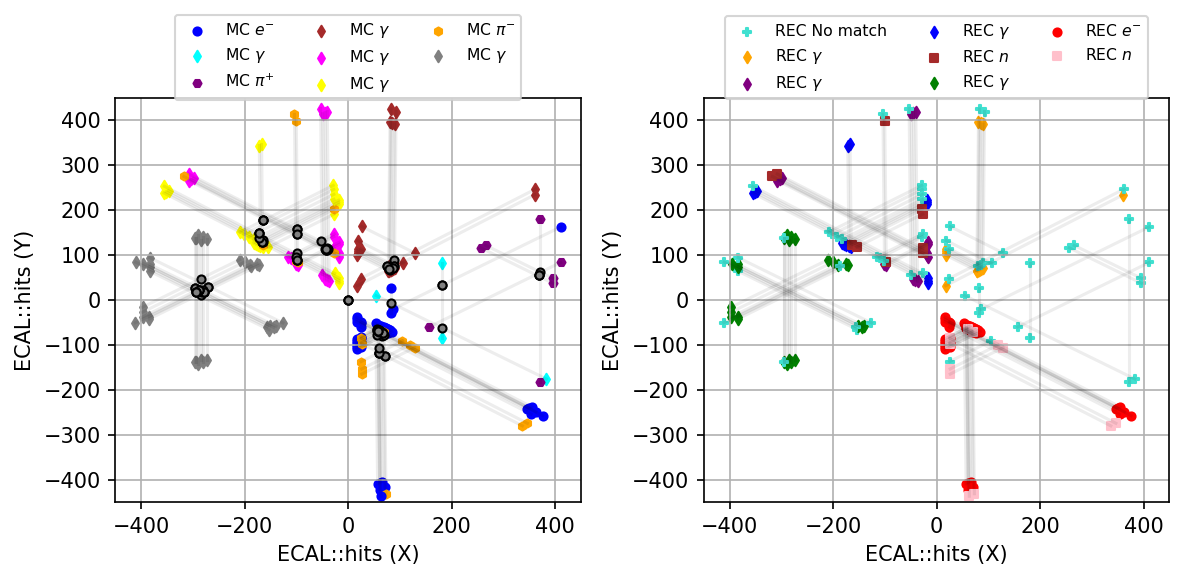

In [33]:
import matplotlib.pyplot as plt
import random
from particle import Particle

# Generate a list of 20 colors
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray',
    'cyan', 'magenta', 'yellow', 'lime', 'maroon', 'navy', 'olive', 'teal',
    'gold', 'violet', 'indigo', 'turquoise'
]
def assign_marker(pid):
    marker_map = {
        11: 'o',  # electron
        2112: 's',  # neutron
        2212: '^',  # proton
        13: 'v',  # muon
        22: 'd',  # photon
        111: 'p',  # pi0
        211: 'H',  # pi+
        -211: 'h',  # pi-
        321: '*',  # K+
        -321: 'X',  # K-
        -1: 'P',  # Background
    }
    return marker_map.get(pid, 'D')  # default to 'D' if PID not in map

def get_particle_name(pid):
    if pid == -1:
        return "No match"
    try:
        particle = Particle.from_pdgid(pid)
        return f"${particle.latex_name}$"
    except Exception:
        return f"PID {pid}"
    
def plot_event(df, event_number):
    # Filter the data for the selected event
    event_data = df[df['event_number'] == event_number]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4),dpi=150)

    axes=axes.flatten()
    
    # Plot 3: lines with endpoints colored by otid, labeling mc_pid
    # Initialize a set to keep track of added `otid`s
    added_otid = set()

    # Prepare a dictionary to accumulate sums for 'xo', 'xe', 'yo', and 'ye' based on `otid`
    otid_sums = {}

    # Iterate through each row in the dataframe
    for _, row in event_data.iterrows():
        color = colors[int(row['otid']) % 20]
        label = f'MC {get_particle_name(row["mc_pid"])}'
        marker = assign_marker(row["mc_pid"])
        otid = int(row['otid'])

        # Sum the 'xo' and 'xe' values, and 'yo' and 'ye' values for each unique `otid`
        if otid not in otid_sums:
            otid_sums[otid] = {'sum_x': 0, 'sum_y': 0, 'count': 0}

        otid_sums[otid]['sum_x'] += row['xo'] + row['xe']
        otid_sums[otid]['sum_y'] += row['yo'] + row['ye']
        otid_sums[otid]['count'] += 2  # Since we're adding both 'xo', 'xe' and 'yo', 'ye'

        if otid not in added_otid:
            axes[0].plot([row['xo'], row['xe']], [row['yo'], row['ye']], color='black', alpha=0.07)
            axes[0].scatter(row['xo'], row['yo'], s=15, marker=marker, color=color, label=label)
            axes[0].scatter(row['xe'], row['ye'], s=15, marker=marker, color=color)
            added_otid.add(otid)
        else:
            axes[0].plot([row['xo'], row['xe']], [row['yo'], row['ye']], color='black', alpha=0.07)
            axes[0].scatter(row['xo'], row['yo'], s=15, marker=marker, color=color)
            axes[0].scatter(row['xe'], row['ye'], s=15, marker=marker, color=color)
        
        #if row['is_2way_same_group']==0:
        #    continue
        #if row['is_3way_same_group']==0:
        #    continue
        axes[0].scatter(row["centroid_x"],row["centroid_y"],s=15,marker="o",color="gray",edgecolor="k",zorder=100)

    # Set labels, legend, grid, and limits
    axes[0].set_xlabel('ECAL::hits (X)')
    axes[0].set_ylabel('ECAL::hits (Y)')
    axes[0].legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3, fontsize=7.5)
    axes[0].grid(True)
    axes[0].set_xlim(-450, 450)
    axes[0].set_ylim(-450, 450)

    # Plot 4: lines with endpoints colored by pindex, labeling rec_pid
    added_pindex = set()
    for _, row in event_data.iterrows():
        color = colors[int(row['pindex']) % 20]
        label = f'REC {get_particle_name(row["rec_pid"])}'
        marker = assign_marker(row["rec_pid"])
        pindex = int(row["pindex"])

        if pindex not in added_pindex:
            axes[1].plot([row['xo'], row['xe']], [row['yo'], row['ye']], color='black', alpha=0.07)
            axes[1].scatter(row['xo'], row['yo'], s=15, marker=marker, color=color, label=label)
            axes[1].scatter(row['xe'], row['ye'], s=15, marker=marker, color=color)
            added_pindex.add(pindex)
        else:
            axes[1].plot([row['xo'], row['xe']], [row['yo'], row['ye']], color='black', alpha=0.07)
            axes[1].scatter(row['xo'], row['yo'], s=15, marker=marker, color=color)
            axes[1].scatter(row['xe'], row['ye'], s=15, marker=marker, color=color)
    axes[1].set_xlabel('ECAL::hits (X)')
    axes[1].set_ylabel('ECAL::hits (Y)')
    axes[1].legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3,fontsize=7.5)
    axes[1].grid(True)
    axes[1].set_xlim(-450, 450)
    axes[1].set_ylim(-450, 450)

    plt.tight_layout()
    plt.show()

# Example usage: Randomly select an event to plot
#random_event = random.choice(df['event_number'].unique())
#print(random_event)
plot_event(df, random_event)


In [21]:
pd.set_option('display.max_rows', 500)

In [22]:
df[df.event_number==2]

,event_number,id,mc_pid,otid,sector,layer,energy,time,xo,yo,...,ye,ze,rec_pid,pindex,centroid_x,centroid_y,is_3way_same_group,is_2way_same_group,is_3way_cross_group,is_2way_cross_group
139,2,1.0,22.0,5.0,1.0,1.0,0.028000,153.663727,256.207092,-127.254242,...,124.174240,668.599792,22.0,1.0,256.841174,31.170912,1,0,0,0
140,2,2.0,22.0,5.0,1.0,2.0,0.019220,157.573059,175.025421,78.072243,...,-39.406048,610.753540,22.0,1.0,256.841174,31.170912,1,0,0,0
141,2,3.0,22.0,5.0,1.0,3.0,0.018920,157.495148,117.336029,-48.296394,...,102.033600,611.858093,22.0,1.0,256.841174,31.170912,1,0,0,0
142,2,11.0,22.0,5.0,1.0,4.0,0.001150,154.329803,255.829712,-117.351814,...,115.847809,704.920105,22.0,1.0,254.524310,42.519706,1,0,0,0
143,2,6.0,22.0,5.0,1.0,4.0,0.002620,153.791916,265.426453,-122.775063,...,121.271057,700.445068,22.0,1.0,267.362539,31.601040,1,1,0,0
144,2,8.0,22.0,5.0,1.0,5.0,0.009030,158.241119,189.056030,78.041290,...,-38.727295,641.070740,22.0,1.0,254.524310,42.519706,1,0,0,0
145,2,15.0,22.0,5.0,1.0,6.0,0.000910,159.027374,396.619629,91.539024,...,-52.615665,760.951294,-1.0,-1.0,265.426453,17.400046,0,1,0,0
146,2,9.0,22.0,5.0,1.0,6.0,0.003990,159.256561,396.619629,102.457695,...,-47.156334,765.456116,-1.0,-1.0,135.839828,-44.912377,1,0,0,1
147,2,20.0,22.0,5.0,1.0,6.0,0.002340,160.558228,396.619629,124.295029,...,-36.237667,774.465759,22.0,1.0,254.524310,42.519706,1,0,0,0
148,2,39.0,22.0,4.0,1.0,7.0,0.003630,151.826736,135.839828,-48.466404,...,46.962406,781.363708,-1.0,-1.0,135.839828,-44.912377,0,0,0,1
